**Information:** *The weekly report supposed to be finished in week 5*

**Written by:** *Zihao Xu*

**Last update date:** *Septtember.28.2021*

# Get control of primitive motions

For completing the task of obstacle avoidance, the next thing to do is to get control of primitive motions such as moving forward or backward. In the existing scripts, a complete trajectory consists of a series of positions, velocities ,accelerations and time stamps is used to guide the drone. It's not convenient enough to use this controlling method when avoiding obstacles.

Probably simple trajectories can be used to achieve the same effect of primitive motion commands, but I would like to check the available service first. If there is indeed no commands for controlling primitive motions, I will then create some commands for obstacle avoidance algorithms.

## Nodes list

Having analyzed the launch file **run_simulation.launch**, now we check the nodes list in simulation for a sanity check. The list is:

- *\/gazebo*
- *\/gazebo_gui*
- *\/hunter/joint_state_publisher*
- *\/hunter/lee_position_controller_node*
- *\/hunter/robot_state_publisher*
- *\/hunter/waypoint_publisher*
- *\/rosout*
- *\/stereo_proc_manager*

To get control of the primitive motions of the Quadcopter, the following nodes will be focused on.

- **Position Controller Node:** 
    - *\/hunter/lee_position_controller_node*
- **State Publisher Nodes:** 
    - *\/hunter/robot_state_publisher*
    - *\/hunter/joint_state_publisher*
- **Path Planning Node** 
    - *\/hunter/waypoint_publisher*

Other nodes are mainly about the Gazebo simulation and will be analyzed later.

## rqt graph

Here is the rqt graph as a guidance.

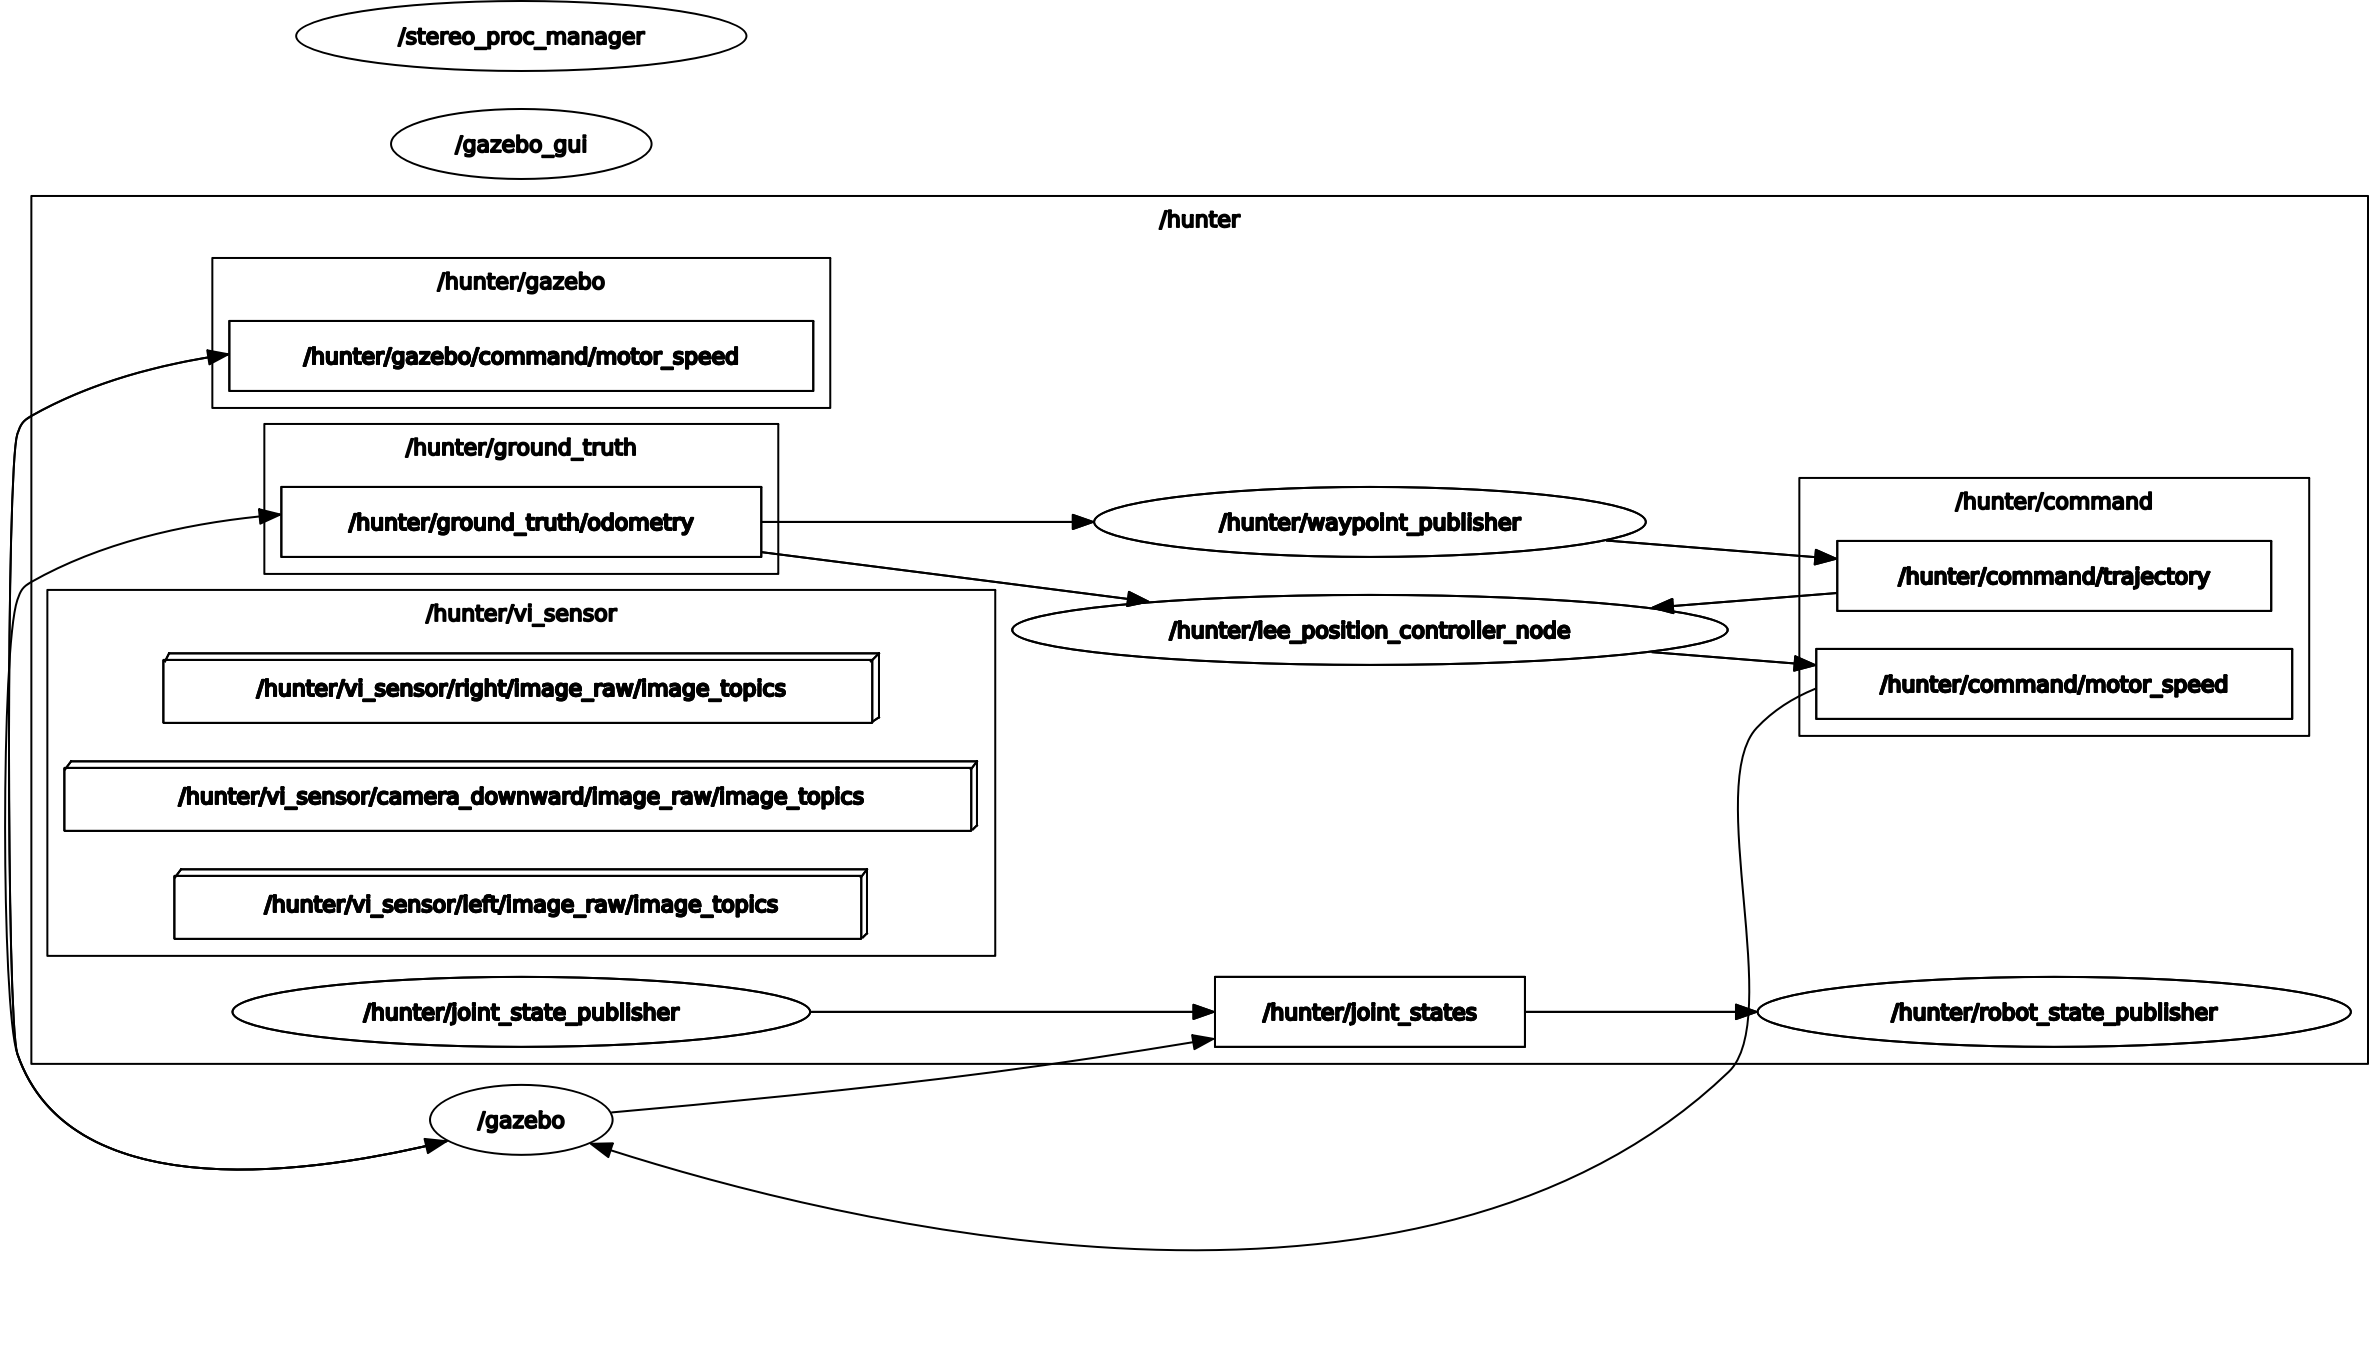

In [1]:
from PIL import Image

img = Image.open("./Figures/weekly_report3_rosgraph.png")
img

## Path Planning Node

This **path planning node** is the node which I modified sometimes earlier by editing the file **follow_waypoints.py**. It's in this python script that a message of type *trajectory_msgs.MultiDOFJointTrajectory* is sent to the topic *command/trajectory* for controlling the drone's movement. In the meantime, it subscribe the message of type 'nav_msgs.msg.Odometry' from the topic *odometry*. Here is a sanity check by calling *``rosnode info /hunter/waypoint_publisher``*. The outputs are:

In [ ]:
Node [/hunter/waypoint_publisher]
Publications: 
 * /hunter/command/trajectory [trajectory_msgs/MultiDOFJointTrajectory]
 * /rosout [rosgraph_msgs/Log]

Subscriptions: 
 * /clock [rosgraph_msgs/Clock]
 * /hunter/ground_truth/odometry [nav_msgs/Odometry]

Services: 
 * /hunter/waypoint_publisher/get_loggers
 * /hunter/waypoint_publisher/set_logger_level


contacting node http://Knoero-Ubuntu:34929/ ...
Pid: 12575
Connections:
 * topic: /rosout
    * to: /rosout
    * direction: outbound (40277 - 127.0.0.1:59958) [10]
    * transport: TCPROS
 * topic: /hunter/command/trajectory
    * to: /hunter/lee_position_controller_node
    * direction: outbound (40277 - 127.0.0.1:59960) [7]
    * transport: TCPROS
 * topic: /clock
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound
    * transport: TCPROS
 * topic: /hunter/ground_truth/odometry
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound
    * transport: TCPROS

The publications and subscriptions are indeed what they are supposed to be.

## State Publisher Nodes

Before checking the position controller node, make clear what these two state publisher nodes are doing. 

### joint_state_publisher

Here is the detailed information of */hunter/joint_state_publisher*.

In [ ]:
Node [/hunter/joint_state_publisher]
Publications: 
 * /hunter/joint_states [sensor_msgs/JointState]
 * /rosout [rosgraph_msgs/Log]

Subscriptions: 
 * /clock [rosgraph_msgs/Clock]

Services: 
 * /hunter/joint_state_publisher/get_loggers
 * /hunter/joint_state_publisher/set_logger_level


contacting node http://Knoero-Ubuntu:34081/ ...
Pid: 12574
Connections:
 * topic: /rosout
    * to: /rosout
    * direction: outbound (40631 - 127.0.0.1:51392) [9]
    * transport: TCPROS
 * topic: /hunter/joint_states
    * to: /hunter/robot_state_publisher
    * direction: outbound (40631 - 127.0.0.1:51394) [11]
    * transport: TCPROS
 * topic: /clock
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound
    * transport: TCPROS

According to the documentation in it, this node publishes *sensor_msgs/JointState* messages for a robot. For a given [URDF](http://wiki.ros.org/urdf), the node reads the *robot_description* parameter from the parameter server, finds all of the non-fixed joints and publishes a *JointState* message with all those joints defined. More details can be find [here](https://wiki.ros.org/joint_state_publisher).

### robot_state_publisher
Here is the detailed information of */hunter/robot_state_publisher*.

In [ ]:
Node [/hunter/robot_state_publisher]
Publications: 
 * /rosout [rosgraph_msgs/Log]
 * /tf [tf2_msgs/TFMessage]
 * /tf_static [tf2_msgs/TFMessage]

Subscriptions: 
 * /clock [rosgraph_msgs/Clock]
 * /hunter/joint_states [sensor_msgs/JointState]

Services: 
 * /hunter/robot_state_publisher/get_loggers
 * /hunter/robot_state_publisher/set_logger_level


contacting node http://Knoero-Ubuntu:40115/ ...
Pid: 12573
Connections:
 * topic: /rosout
    * to: /rosout
    * direction: outbound (57115 - 127.0.0.1:33336) [11]
    * transport: TCPROS
 * topic: /clock
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound (41634 - Knoero-Ubuntu:48829) [14]
    * transport: TCPROS
 * topic: /hunter/joint_states
    * to: /hunter/joint_state_publisher (http://Knoero-Ubuntu:34081/)
    * direction: inbound (51394 - Knoero-Ubuntu:40631) [13]
    * transport: TCPROS
 * topic: /hunter/joint_states
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound (41732 - Knoero-Ubuntu:48829) [16]
    * transport: TCPROS

According to the documentation in its **package.xml**, this node publishes the state of a robot to *[tf2](https://wiki.ros.org/tf2)*. It takes the joint angles of the robot as input and publishes the 3D poses of the robot links, using a kinematic tree model of the robot. Detailed information can be viewed [here](http://wiki.ros.org/robot_state_publisher).
In this subject, It uses the URDF specified by the parameter *robot_description* and the joint positions from the topic *joint_states* to calculate the forward kinematics of the robot and publish the results.

## lee_position_controller_node

Now let's focus on the controller node. It's from the **[RotorS](https://github.com/ethz-asl/rotors_simulator/wiki)** package. First print out the details of this node.

In [ ]:
Node [/hunter/lee_position_controller_node]
Publications: 
 * /hunter/command/motor_speed [mav_msgs/Actuators]
 * /rosout [rosgraph_msgs/Log]

Subscriptions: 
 * /clock [rosgraph_msgs/Clock]
 * /hunter/command/pose [unknown type]
 * /hunter/command/trajectory [trajectory_msgs/MultiDOFJointTrajectory]
 * /hunter/ground_truth/odometry [nav_msgs/Odometry]

Services: 
 * /hunter/lee_position_controller_node/get_loggers
 * /hunter/lee_position_controller_node/set_logger_level


contacting node http://Knoero-Ubuntu:39795/ ...
Pid: 12564
Connections:
 * topic: /rosout
    * to: /rosout
    * direction: outbound (52087 - 127.0.0.1:43010) [13]
    * transport: TCPROS
 * topic: /hunter/command/motor_speed
    * to: /gazebo
    * direction: outbound (52087 - 127.0.0.1:43164) [17]
    * transport: TCPROS
 * topic: /clock
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound (41640 - Knoero-Ubuntu:48829) [14]
    * transport: TCPROS
 * topic: /hunter/command/trajectory
    * to: /hunter/waypoint_publisher (http://Knoero-Ubuntu:34929/)
    * direction: inbound (59960 - Knoero-Ubuntu:40277) [10]
    * transport: TCPROS
 * topic: /hunter/ground_truth/odometry
    * to: /gazebo (http://Knoero-Ubuntu:36831/)
    * direction: inbound (41734 - Knoero-Ubuntu:48829) [12]
    * transport: TCPROS

It seems that it only receives two message types: *trajectory* and *motor_speed*. There are no handles controlling the primitive motions. 

## RotorS: Usage with a joystick

I checked the github repo of the **RotorS** package, which provides the controller with a joystick. The example launch file is located at *src/drone_boat_simulation/rotors_simulators/rotors_gazebo/launch/mav_with_joy.launch*. The launch commands for related nodes for joystick controller are listed below.

In [ ]:
    <node name="joy_node" pkg="joy" type="joy_node" />
    <node name="rotors_joy_interface" pkg="rotors_joy_interface" type="rotors_joy_interface" />
    <node name="roll_pitch_yawrate_thrust_controller_node" pkg="rotors_control" type="roll_pitch_yawrate_thrust_controller_node" output="screen">
      <rosparam
        command="load" file="$(find rotors_gazebo)/resource/roll_pitch_yawrate_thrust_controller_$(arg mav_name).yaml" />
      <rosparam command="load" file="$(find rotors_gazebo)/resource/$(arg mav_name).yaml" />
      <remap from="odometry" to="odometry_sensor1/odometry" />
    </node>

Seems that the *roll_pitch_yawrate_thrust_controller_node* is the key of this controlling mode but I haven't read through the *cpp* scripts yet. Its directory is *src/drone_boat_simulation/rotors_simulators/rotors_control/src/nodes/roll_pitch_yawrate_thrust_controller_node.cpp*.

# Gazebo worlds

There are several basic worlds in the **Rotors** package in the folder *.../rotors_simulators/rotors_gazebo/worlds*. To change the gazebo environment, just edit the argument *world_name*.

I'm planing to use some simple worlds in that folder to test the basic functions of the obstacle avoidance algorithm. A custom gazebo world will be created after the algorithm passes the test.

# Summary and future work

**In the past one week, I**

- Got a deep understanding of which topics and nodes are working and how they are functioning
- Read through the documents of **RotorS** package, which is the core of the current simulation program
- Read through the *cpp* scripts of *lee_position_controller_node* and made sure no commands for primitive motions are available
- Tested several different Gazebo worlds built in the **RotorS** package

**In the next few weeks, I'm planing to**

- Read through the *cpp* scripts of *roll_pitch_yawrate_thrust_controller_node* and find a way to control the primitive motions
- Create some handy commands for primitive motions, for future use
- Find a way to get the vision input from the camera.